# Import Libraries

In [12]:
import pandas as pd
import numpy as np
import h5py
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import string as st
from imblearn.combine import SMOTETomek

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Function

In [2]:
def preprocess_text(text):
    doc = nlp(text.lower().strip())  # Lowercase and remove whitespace
    
    # Remove stopwords, punctuation, and lemmatize
    tokens = [token.lemma_ for token in doc 
             if not token.is_stop and not token.is_punct and token.is_alpha]
    
    return ' '.join(tokens)

In [3]:
def extract_linguistic_features(text):
    doc = nlp(text)
    features = {
        'num_verbs': len([token for token in doc if token.pos_ == 'VERB']),
        'num_nouns': len([token for token in doc if token.pos_ == 'NOUN']),
        'sentence_length': len(doc),
        'blooms_verb_present': any(token.text in {'analyze', 'evaluate', 'create'} for token in doc)
    }
    return features

# Pre Processing

In [6]:
label_mapper = {
    'BT1' : 'knowledge',
    'BT2' : 'comprehension',
    'BT3' : 'application',
    'BT4' : 'analysis',
    'BT5' : 'synthesis',
    'BT6' : 'evaluation'
}

# Load dataset
df = pd.DataFrame()
for i in range(1,5):
    q_df = pd.read_csv(os.getcwd().replace('notebook' , 'dataset') + '/dataset' + str(i) + '.csv')
    df = pd.concat([df , q_df])

# Apply preprocessing
mask = df['label'].isin(label_mapper.keys())
df['label'] = df['label'].mask(mask, df['label'].map(label_mapper))
df['label'] = df['label'].str.lower()

df['processed_question'] = df['question'].apply(preprocess_text)

In [9]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features= 500)
tfidf = vectorizer.fit_transform(df['processed_question'])

# Convert TF-IDF sparse matrix to DataFrame with appropriate column names
tfidf_df = pd.DataFrame(tfidf.toarray(), columns= vectorizer.get_feature_names_out())

In [11]:
tfidf_df

,access,accuracy,achieve,action,activity,advantage,advertising,affect,air,algorithm,...,wave,way,web,wind,wireless,word,work,working,write,year
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10703,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10704,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10705,0.0,0.0,0.0,0.0,0.0,0.333169,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10706,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Extraction

### Add Linguistic Features

In [ ]:
ling_features = df['processed_question'].apply(extract_linguistic_features).apply(pd.Series)
X_features = pd.concat([ling_features, pd.DataFrame(tfidf.toarray())], axis=1)

### Dataset Label Balancing

In [13]:
x , y = tfidf_df , df['label']
x_resampled , y_resampled = SMOTETomek().fit_resample(x , y)

### Dimensionality Reduction

# Analysis

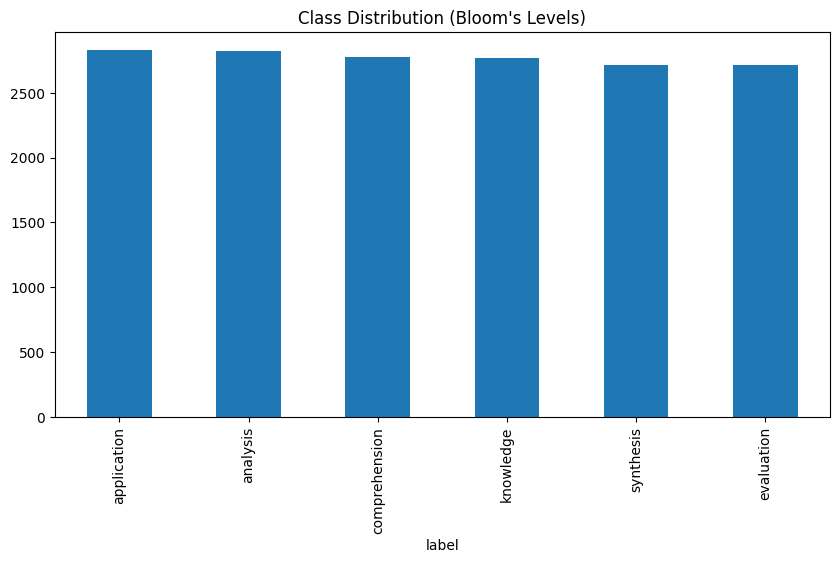

In [15]:
plt.figure(figsize=(10,5))
y_resampled.value_counts().plot(kind='bar')
plt.title('Class Distribution (Bloom\'s Levels)')
plt.show()